# ESRB rating machine learning

In [1]:
%pip install numpy==1.24.1
%pip install pandas==1.5.3
%pip install seaborn==0.12.2
%pip install scikit-learn==1.2.0
%pip install plotly==5.12.0
%pip install matplotlib==3.6.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import general libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [3]:
# CSV file with the ESRB rating data
df = pd.read_csv('Video_games_esrb_rating.csv')

In [4]:
df.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


## Pre processing

In [5]:
# Correcting typo in the original dataframe
df = df.rename(columns={"strong_janguage": "strong_language"})

In [6]:
# check all columns
# check if there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     1895 non-null   object
 1   console                   1895 non-null   int64 
 2   alcohol_reference         1895 non-null   int64 
 3   animated_blood            1895 non-null   int64 
 4   blood                     1895 non-null   int64 
 5   blood_and_gore            1895 non-null   int64 
 6   cartoon_violence          1895 non-null   int64 
 7   crude_humor               1895 non-null   int64 
 8   drug_reference            1895 non-null   int64 
 9   fantasy_violence          1895 non-null   int64 
 10  intense_violence          1895 non-null   int64 
 11  language                  1895 non-null   int64 
 12  lyrics                    1895 non-null   int64 
 13  mature_humor              1895 non-null   int64 
 14  mild_blood              

In [7]:
# drop the title and console columns, because it is not needed for the analysis
df.drop(['title', 'console'], inplace=True, axis=1)

In [8]:
ratings = df['esrb_rating'].unique()
ratings

array(['E', 'ET', 'M', 'T'], dtype=object)

In [9]:
df.head()

,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,...,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ET
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,T


In [10]:
# Replace the ESRB ratings with numbers, this is needed for some of the models
df['esrb_rating'] = df['esrb_rating'].replace(
    'E', 0).replace('ET', 1).replace('T', 2).replace('M', 3)

In [11]:
y = df['esrb_rating']
X = df.drop(['esrb_rating'], axis=1)

## Splitting dataset

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=SEED)

## Decision tree (Anwar Ammour)

In [13]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [14]:
# Make predictions
y_pred_tree = classifier.predict(X_test)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[ 96   2   1   0]
 [  4  51   6   0]
 [  2  19 118   7]
 [  0   0  12  61]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        99
           1       0.71      0.84      0.77        61
           2       0.86      0.81      0.83       146
           3       0.90      0.84      0.87        73

    accuracy                           0.86       379
   macro avg       0.85      0.86      0.86       379
weighted avg       0.86      0.86      0.86       379



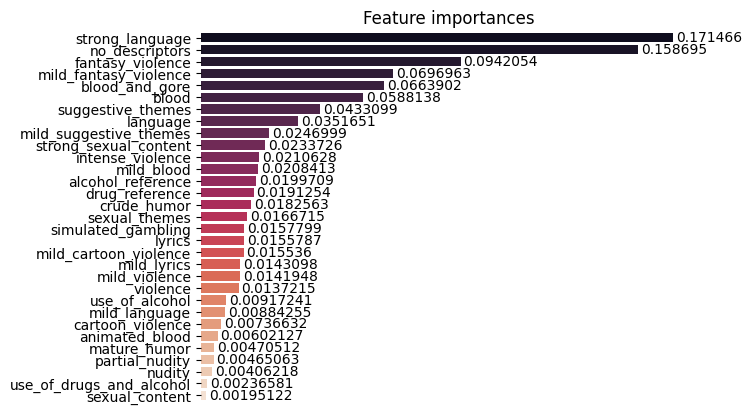

In [16]:
# print feature importance
features_df = pd.DataFrame(
    {'features': classifier.feature_names_in_, 'importances': classifier.feature_importances_})

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted, x='importances',
                y='features', palette="rocket")
sns.despine(bottom=True, left=True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

## Random Forest (Remco de Wilde)

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Create instance of random forest classifier
rfc = RandomForestClassifier(n_estimators=20,
                             max_depth=11,
                             random_state=SEED)

In [18]:
# Train the classifier
rfc.fit(X_train, y_train)
# Predict the labels of the test set
y_pred_rt = rfc.predict(X_test)

In [19]:
features = X.columns.values  # The name of each column

# for estimator in rfc.estimators_:
#     print(estimator)
#     plt.figure(figsize=(12, 6))
#     tree.plot_tree(estimator,
#                    feature_names=features,
#                    class_names=ratings,
#                    fontsize=8,
#                    filled=True,
#                    rounded=True)
#     plt.show()

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        99
           1       0.70      0.69      0.69        61
           2       0.76      0.85      0.80       146
           3       0.94      0.86      0.90        73

    accuracy                           0.83       379
   macro avg       0.84      0.82      0.83       379
weighted avg       0.84      0.83      0.84       379



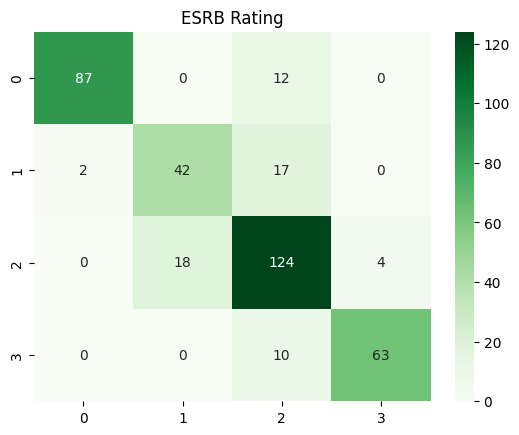

In [20]:
cm = confusion_matrix(y_test, y_pred_rt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens').set_title('ESRB Rating')

print(classification_report(y_test,y_pred_rt))

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_rt))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_rt))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_rt)))

Mean Absolute Error: 0.19788918205804748
Mean Squared Error: 0.2612137203166227
Root Mean Squared Error: 0.5110907163279556


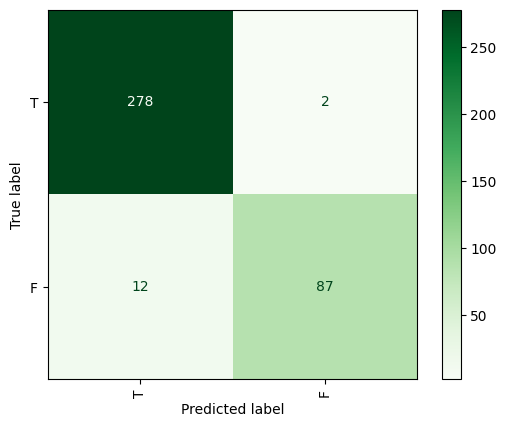

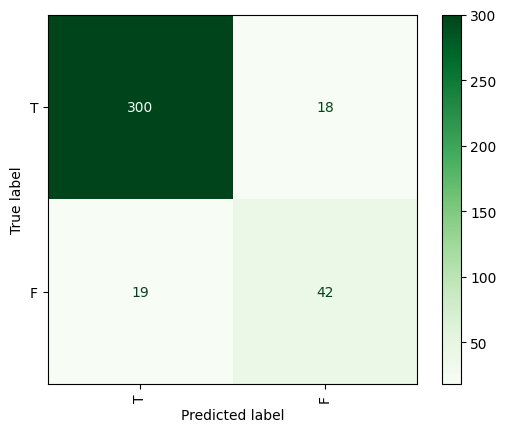

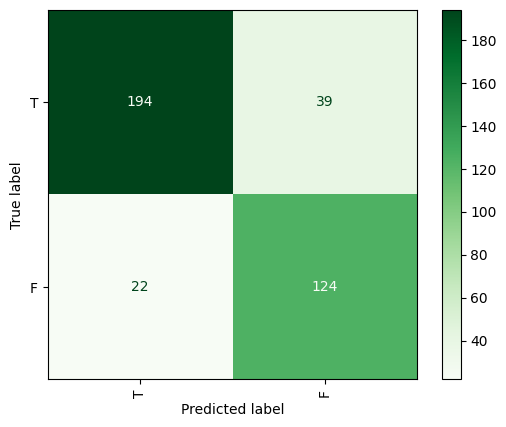

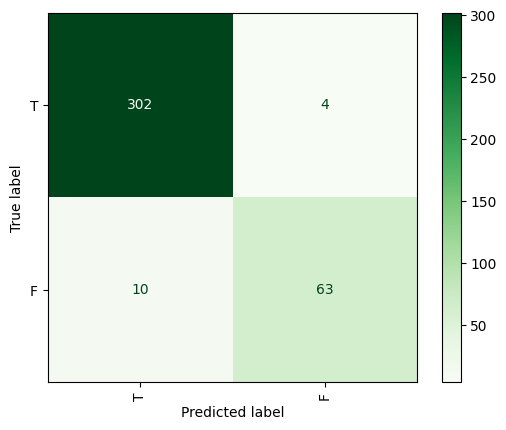

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred_rt)

for confusion_matrix in mcm:
    disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=['T','F'])
    disp.plot(include_values=True, cmap="Greens", ax=None, xticks_rotation="vertical")
    plt.show()

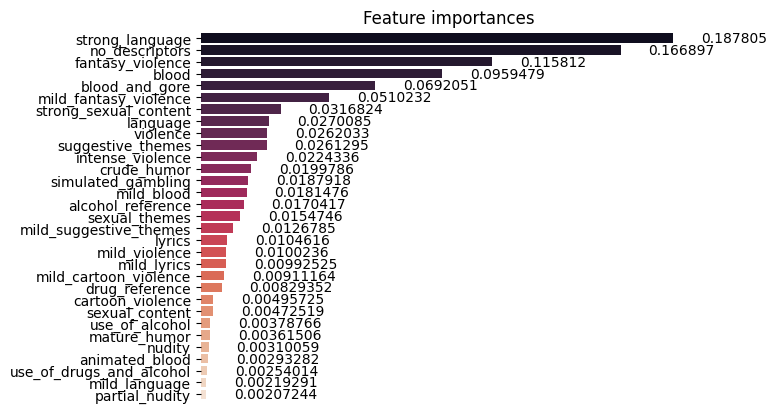

In [23]:
# Create a dataframe with the features and their importance
features_df = pd.DataFrame(
    {'features': rfc.feature_names_in_, 'importances': rfc.feature_importances_})

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted, x='importances',
                y='features', palette="rocket")
sns.despine(bottom=True, left=True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=20)
    g.margins(y=0.005)

## k-NN (Thom Hooijer)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()

In [25]:
# Scale both X_train and X_test
X_train_knn = scaler.fit_transform(X_train)
X_test_knn = scaler.transform(X_test)

In [26]:
# Create a KNN classifier
knnc = KNeighborsClassifier()
knnc.fit(X_train_knn, y_train)

KNeighborsClassifier()

In [27]:
# Predict the classes of the test data
y_pred_knn = knnc.predict(X_test_knn)

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.values, y_pred_knn)

array([[ 97,   1,   1,   0],
       [  7,  39,  15,   0],
       [  2,  21, 111,  12],
       [  1,   0,  11,  61]], dtype=int64)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        99
           1       0.64      0.64      0.64        61
           2       0.80      0.76      0.78       146
           3       0.84      0.84      0.84        73

    accuracy                           0.81       379
   macro avg       0.80      0.80      0.80       379
weighted avg       0.81      0.81      0.81       379



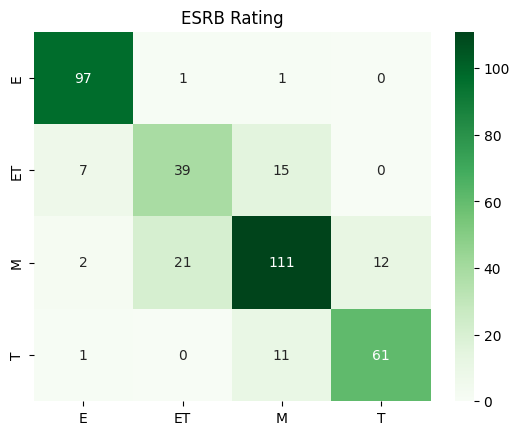

In [46]:
# Adding classes names for better interpretation
classes_names = ratings
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_knn), 
                  columns=classes_names, index = classes_names)
                  
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens').set_title('ESRB Rating')
print(classification_report(y_test, y_pred_knn))

In [30]:
from sklearn.metrics import f1_score
f1s = []

# Calculating f1 score for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # using average='weighted' to calculate a weighted average for the 4 classes 
    f1s.append(f1_score(y_test, pred_i, average='weighted'))

Text(0, 0.5, 'F1 Score')

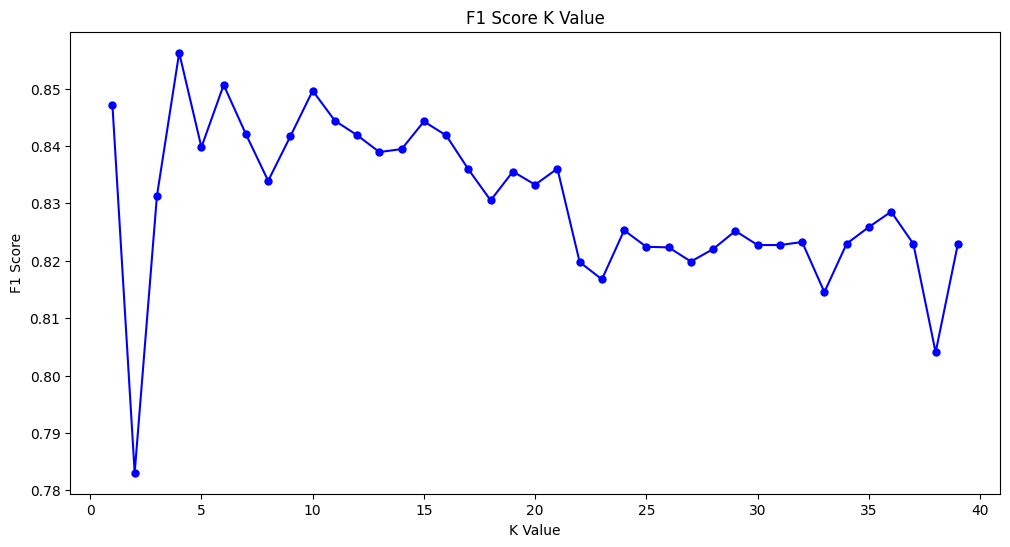

In [31]:
# Plotting the f1 score for each K value
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), f1s, color='blue', marker='.',
         markerfacecolor='blue', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

In [32]:
# Plotting the f1 score for each K value
t = pd.DataFrame(f1s)

In [33]:
# Get the index of the maximum f1 score value, this is the optimal K value
optimal_n_index_value = t.idxmax().tolist()[0]
# Add 1 to fix the index
optimal_n_index_value += 1

In [34]:
# Create a KNN classifier with a optimal k value (K=6)
optimal_knn_classifier = KNeighborsClassifier(n_neighbors=optimal_n_index_value)
optimal_knn_classifier.fit(X_train, y_train)
optimal_knn_pred = optimal_knn_classifier.predict(X_test)
print(classification_report(y_test, optimal_knn_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        99
           1       0.66      0.85      0.74        61
           2       0.90      0.77      0.83       146
           3       0.93      0.85      0.89        73

    accuracy                           0.85       379
   macro avg       0.85      0.86      0.85       379
weighted avg       0.87      0.85      0.86       379



## Support Vector Machine (Remco de Wilde)

In [35]:
from sklearn.svm import SVC

In [36]:
# Create the model
svclassifier = SVC(kernel='linear', probability=True)
# Train the model
svclassifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [37]:
# Make predictions
y_pred_svm = svclassifier.predict(X_test)

Text(0.5, 1.0, 'ESRB Rating')

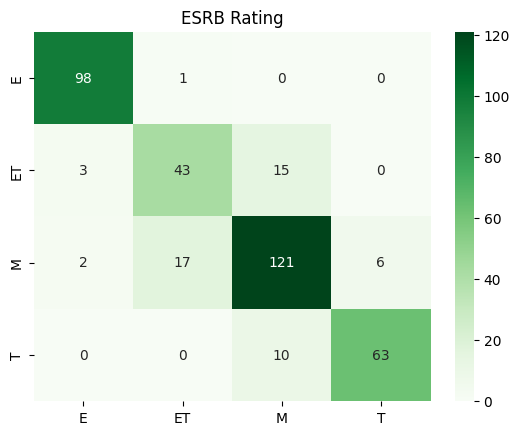

In [38]:
# Evaluate the model
cm = confusion_matrix(y_test,y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=ratings, yticklabels=ratings).set_title('ESRB Rating')

In [39]:
# Print the classification report
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        99
           1       0.70      0.70      0.70        61
           2       0.83      0.83      0.83       146
           3       0.91      0.86      0.89        73

    accuracy                           0.86       379
   macro avg       0.85      0.85      0.85       379
weighted avg       0.86      0.86      0.86       379



## Ensamble Voting Classifier (Remco de Wilde)

In [40]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('RF', rfc), ('DT', classifier), ('SVC', svclassifier), ('KNN', optimal_knn_classifier)],
                        voting='soft')

In [41]:
# Training the voting classifier
eclf = eclf.fit(X, y)

In [42]:
y_pred_eclf = eclf.predict(X_test)

In [43]:
cm = confusion_matrix(y_test,y_pred_eclf)

Text(0.5, 1.0, 'ESRB Rating')

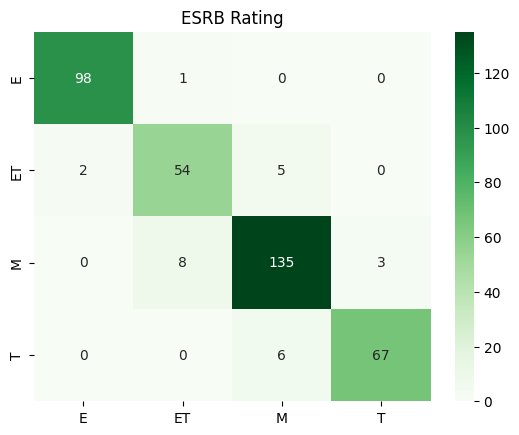

In [44]:
Labels = ratings
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=Labels, yticklabels=Labels).set_title('ESRB Rating')

In [45]:
# Printing the classification report
print(classification_report(y_test,y_pred_eclf))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        99
           1       0.86      0.89      0.87        61
           2       0.92      0.92      0.92       146
           3       0.96      0.92      0.94        73

    accuracy                           0.93       379
   macro avg       0.93      0.93      0.93       379
weighted avg       0.93      0.93      0.93       379

